In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.res_conv = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        res = self.res_conv(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += res
        return F.relu(x)

class EncoderDecoderModel(nn.Module):
    def __init__(self, input_shape):
        super(EncoderDecoderModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),
            ResidualBlock(32, 64),
            nn.MaxPool2d(2, padding=1),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2, padding=1),
            ResidualBlock(128, 256),
            nn.MaxPool2d(2, padding=1)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            ResidualBlock(256, 128),
            nn.Upsample(scale_factor=2, mode='nearest'),
            ResidualBlock(128, 64),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        classification = self.classifier(encoded)
        return decoded, classification

class EncoderOnlyModel(nn.Module):
    def __init__(self, input_shape):
        super(EncoderOnlyModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),
            ResidualBlock(32, 64),
            nn.MaxPool2d(2, padding=1),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2, padding=1),
            ResidualBlock(128, 256),
            nn.MaxPool2d(2, padding=1)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        classification = self.classifier(encoded)
        return encoded, classification

# Define input shape
input_shape = (1, 1024, 1024)

# Instantiate the models
encoder_decoder_model = EncoderDecoderModel(input_shape)
encoder_only_model = EncoderOnlyModel(input_shape)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(encoder_decoder_model.parameters(), lr=0.001)

# Example of how to compile the models
encoder_decoder_model.compile = lambda: (encoder_decoder_model.train(), optimizer)
encoder_only_model.compile = lambda: (encoder_only_model.train(), optimizer)

# Compile the models
encoder_decoder_model.compile()
encoder_only_model.compile()

(EncoderOnlyModel(
   (encoder): Sequential(
     (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
     (3): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (res_conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
     )
     (4): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
     (5): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(128, 128, kern

Using device: cuda


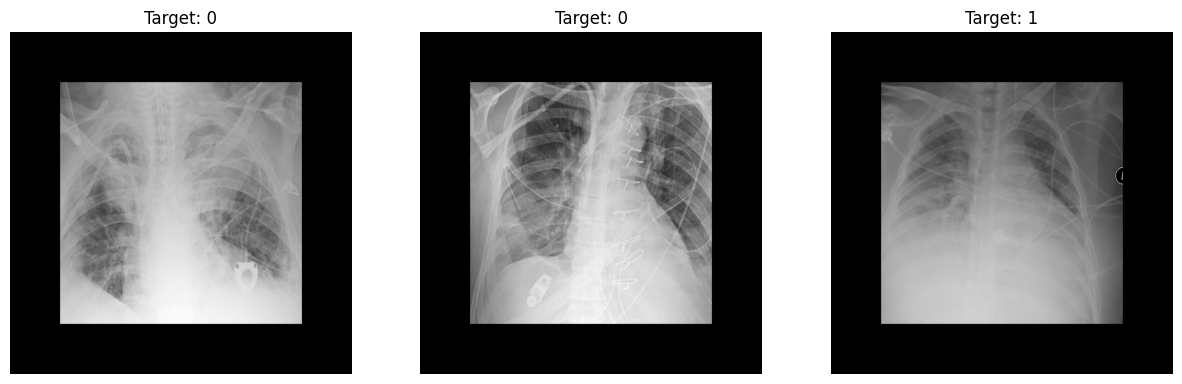

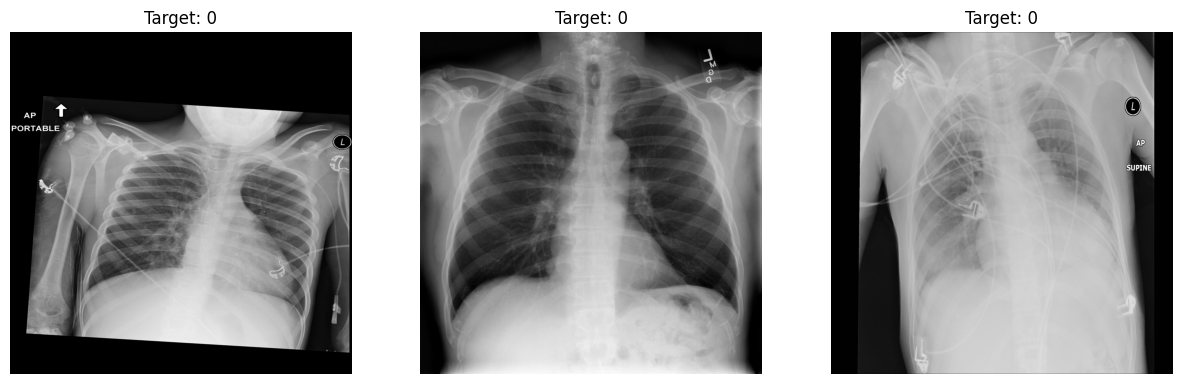

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import pydicom
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

class PneumoniaDataset(Dataset):
    def __init__(self, images_folder, labels_csv, subset, training=False, transform=None):
        labels_df = pd.read_csv(labels_csv)
        train_df, test_df = train_test_split(labels_df, test_size=0.15, random_state=42, stratify=labels_df["Target"])
        train_df, eval_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df["Target"])  # 0.25 * 0.8 = 0.2
        
        if subset == 'train':
            self.labels_df = train_df
        elif subset == 'eval':
            self.labels_df = eval_df
        elif subset == 'test':
            self.labels_df = test_df
        else:
            raise ValueError("Subset must be 'train', 'eval', or 'test'")
        
        self.images_folder = images_folder
        self.transform = transform
        self.training = training
    
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        try:
            row = self.labels_df.iloc[idx]
            patient_id = row['patientId']
            x = row['x'] if not pd.isna(row['x']) else 0
            y = row['y'] if not pd.isna(row['y']) else 0
            width = row['width'] if not pd.isna(row['width']) else 0
            height = row['height'] if not pd.isna(row['height']) else 0
            target = row['Target']
            
            image_path = os.path.join(self.images_folder, patient_id + ".dcm")
            if not os.path.exists(image_path):
                print(f"Warning: {image_path} does not exist. Skipping.")
                return None
            
            dicom = pydicom.dcmread(image_path)
            image = dicom.pixel_array
            image = np.expand_dims(image, axis=-1)  # Add channel dimension
            
            if self.transform:
                image = self.transform(image)

            if self.training:
                image[0][:150, :] = 0
                image[0][-150:, :] = 0
                image[0][:, :150] = 0
                image[0][:, -150:] = 0
            
            boxes = torch.tensor([x, y, width, height], dtype=torch.float32)
            return image, boxes, target
        except Exception as e:
            print(f"Error processing {patient_id}: {e}")
            return None

def preprocess_image(image):
    image = torch.tensor(image, dtype=torch.float32)
    image = image.permute(2, 0, 1)  # Change to CxHxW
    image = image / 1024.0
    return image

def load_model(model, optimizer, path):
    if os.path.exists(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Loaded model from {path}, epoch: {checkpoint['epoch']}")
        return model, optimizer, checkpoint['epoch']
    else:
        print(f"No saved model found at {path}, training from scratch.")
        return model, optimizer, 0

def train_model(model, dataloader, criterion, optimizer, start_epoch, num_epochs, model_name):
    model.train()
    for epoch in range(start_epoch, num_epochs):
        running_loss = 0.0
        for batch in tqdm(dataloader):
            if batch is None:
                continue
            images, boxes, targets = batch
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs, classification_output = model(images)
            classification_output = classification_output.view(-1)
            loss = criterion(classification_output, targets.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")
        torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f"/repo/ModelsV2/{model_name}")


def show_examples(dataset, num_examples=3):
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    for i in range(num_examples):
        image, boxes, target = dataset[i]
        image = image.permute(1, 2, 0).numpy() * 1024.0  # Convert back to HxWxC and rescale
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Target: {target}')
        axes[i].axis('off')
    plt.show()

images_folder = '/repo/stage_2_train_images'
labels_csv = '/repo/stage_2_train_labels.csv'
batch_size = 8  # Reduce batch size to reduce memory usage

train_dataset = PneumoniaDataset(images_folder, labels_csv, subset='train', training=True, transform=preprocess_image)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)  # Use 0 workers for debugging

test_dataset = PneumoniaDataset(images_folder, labels_csv, subset='test', training=False, transform=preprocess_image)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

show_examples(train_dataset)
show_examples(test_dataset)


In [12]:
encoder_decoder_model_path = "/repo/ModelsV2/encoder_decoder_model.pt"
encoder_only_model_path = "/repo/ModelsV2/encoder_only_model.pt"

input_shape = (1, 1024, 1024)
encoder_decoder_model = EncoderDecoderModel(input_shape).to(device)
encoder_only_model = EncoderOnlyModel(input_shape).to(device)

optimizer_ed = optim.Adam(encoder_decoder_model.parameters(), lr=0.001)
optimizer_eo = optim.Adam(encoder_only_model.parameters(), lr=0.001)

criterion = nn.BCELoss()

total_epochs = 25  # Set the total number of epochs you want to train

encoder_decoder_model, optimizer_ed, start_epoch_ed = load_model(encoder_decoder_model, optimizer_ed, encoder_decoder_model_path)

if start_epoch_ed < total_epochs:
    train_model(encoder_decoder_model, train_loader, criterion, optimizer_ed, start_epoch_ed, total_epochs, "encoder_decoder_model.pt")
else:
    print("Encoder-Decoder model already trained.")

encoder_only_model, optimizer_eo, start_epoch_eo = load_model(encoder_only_model, optimizer_eo, encoder_only_model_path)

if start_epoch_eo < total_epochs:
    train_model(encoder_only_model, train_loader, criterion, optimizer_eo, start_epoch_eo, total_epochs, "encoder_only_model.pt")
else:
    print("Encoder-Only model already trained.")

Loaded model from /repo/ModelsV2/encoder_decoder_model.pt, epoch: 10


  0%|          | 7/2891 [00:01<11:10,  4.30it/s]

100%|██████████| 2891/2891 [11:19<00:00,  4.26it/s]


Epoch 11/25, Loss: 0.4382781797768088


100%|██████████| 2891/2891 [11:19<00:00,  4.26it/s]


Epoch 12/25, Loss: 0.4318400506292277


100%|██████████| 2891/2891 [11:19<00:00,  4.25it/s]


Epoch 13/25, Loss: 0.4264379717365799


100%|██████████| 2891/2891 [11:18<00:00,  4.26it/s]


Epoch 14/25, Loss: 0.42783522992986


100%|██████████| 2891/2891 [11:19<00:00,  4.25it/s]


Epoch 15/25, Loss: 0.4227334365289915


100%|██████████| 2891/2891 [11:18<00:00,  4.26it/s]


Epoch 16/25, Loss: 0.41951328660069925


100%|██████████| 2891/2891 [11:18<00:00,  4.26it/s]


Epoch 17/25, Loss: 0.41718362470613923


 22%|██▏       | 638/2891 [02:30<08:50,  4.25it/s]


KeyboardInterrupt: 

In [ ]:
# from sklearn.metrics import accuracy_score

# def evaluate_model(model, dataloader, criterion):
#     model.eval()
#     all_targets = []
#     all_predictions = []
#     with torch.no_grad():
#         for batch in tqdm(dataloader):
#             if batch is None:
#                 continue
#             images, boxes, targets = batch
#             images, targets = images.to(device), targets.to(device)
#             _, classification_output = model(images)
#             classification_output = classification_output.view(-1)
#             predictions = (classification_output > 0.5).float()
#             all_targets.extend(targets.cpu().numpy())
#             all_predictions.extend(predictions.cpu().numpy())
    
#     accuracy = accuracy_score(all_targets, all_predictions)
#     print(f"Accuracy: {accuracy}")

# # Evaluate the models
# print("Evaluating Encoder-Decoder Model")
# evaluate_model(encoder_decoder_model, test_loader, criterion)

# print("Evaluating Encoder-Only Model")
# evaluate_model(encoder_only_model, test_loader, criterion)

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from skimage.transform import resize
from tqdm import tqdm

class CAMGenerator:
    def __init__(self, model, target_layer_name, device):
        self.model = model
        self.target_layer = dict([*model.named_modules()])[target_layer_name]
        self.device = device
        self.activations = None
        self.gradients = None
        self.register_hooks()

    def register_hooks(self):
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate(self, image):
        self.model.eval()
        image = image.unsqueeze(0).to(self.device)

        with torch.enable_grad():
            image.requires_grad = True
            output = self.model(image)
            pred_class = output[1].argmax(dim=1).item()
            pred_score = output[1][0][pred_class]
            self.model.zero_grad()
            pred_score.backward()

        activation = self.activations.detach().cpu().numpy()[0]
        gradient = self.gradients.detach().cpu().numpy()[0]

        pooled_gradients = np.mean(gradient, axis=(1, 2))
        for i in range(activation.shape[0]):
            activation[i, :, :] *= pooled_gradients[i]

        heatmap = np.mean(activation, axis=0)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        heatmap = resize(heatmap, (image.shape[2], image.shape[3]))

        del image
        torch.cuda.empty_cache()

        return heatmap

def evaluate_model(model, dataloader, device, target_layer_name):
    cam_generator = CAMGenerator(model, target_layer_name, device)

    def calculate_cam_percentage(heatmap, bbox):
        x_min, y_min, x_max, y_max = map(int, bbox)
        cam_inside_box = heatmap[y_min:y_min+y_max, x_min:x_min+x_max].sum()
        total_cam = heatmap.sum()
        return cam_inside_box / total_cam if total_cam > 0 else 0

    model.eval()
    targets, predictions, cam_percentages = [], [], []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            if batch is None:
                continue
            images, bboxes, batch_targets = batch
            images, batch_targets = images.to(device), batch_targets.to(device)
            outputs = model(images)
            batch_predictions = outputs[1].cpu().numpy()

            targets.extend(batch_targets.cpu().numpy())
            predictions.extend(batch_predictions)

            for i in range(len(batch_targets)):
                if batch_targets[i] > 0 and batch_predictions[i] > 0.5:
                    heatmap = cam_generator.generate(images[i])
                    cam_percentage = calculate_cam_percentage(heatmap, bboxes[i])
                    cam_percentages.append(cam_percentage)

            del images, bboxes, batch_targets, outputs, batch_predictions
            torch.cuda.empty_cache()

    accuracy = np.mean(np.array(targets) == (np.array(predictions) > 0.5))
    avg_cam_percentage = np.mean(cam_percentages) if cam_percentages else 0

    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Average CAM percentage inside bounding box: {avg_cam_percentage * 100:.2f}%')

# Assume DataLoader `dataloader` and `device` setup here

# Define last convolutional layer names for each model
encoder_decoder_last_conv_layer = 'encoder.8'
encoder_only_last_conv_layer = 'encoder.8'

# Evaluate Encoder-Decoder Model
print("Evaluating Encoder-Decoder Model")
evaluate_model(encoder_decoder_model, test_loader, device, encoder_decoder_last_conv_layer)

#Evaluate Encoder-Only Model
print("Evaluating Encoder-Only Model")
evaluate_model(encoder_only_model, test_loader, device, encoder_only_last_conv_layer)


Evaluating Encoder-Decoder Model


100%|██████████| 4535/4535 [01:28<00:00, 51.14it/s]


Accuracy: 63.91%
Average CAM percentage inside bounding box: 18.22%
Evaluating Encoder-Only Model


100%|██████████| 4535/4535 [01:40<00:00, 45.17it/s]


Accuracy: 39.22%
Average CAM percentage inside bounding box: 10.43%


Plotting CAM examples for Encoder-Decoder Model


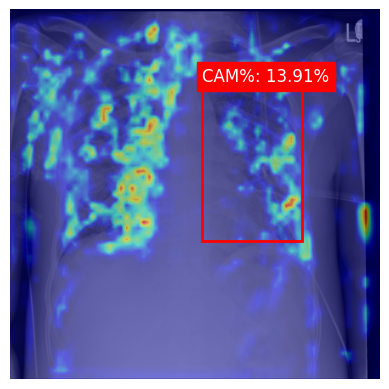

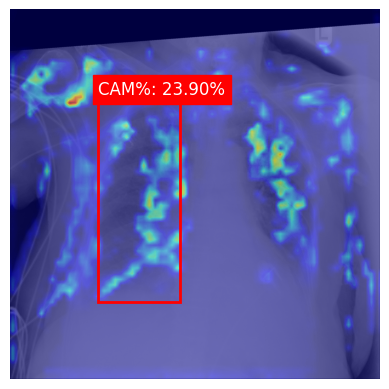

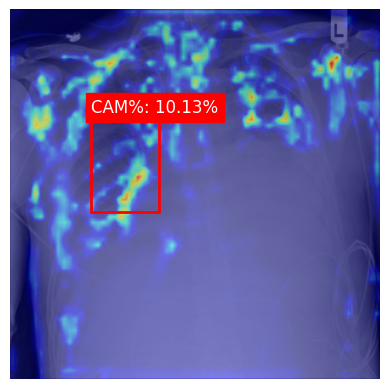

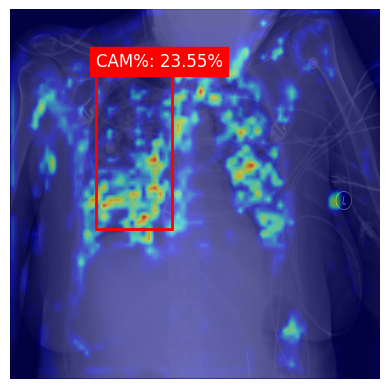

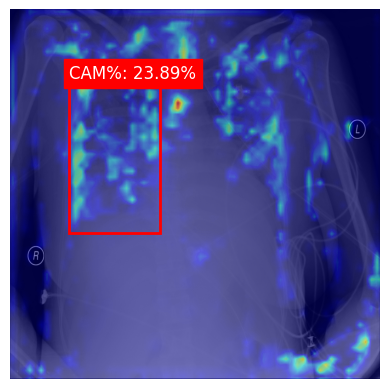

Plotting CAM examples for Encoder-Only Model


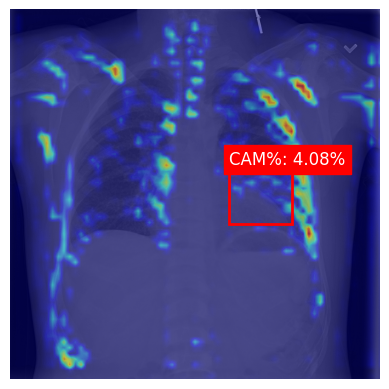

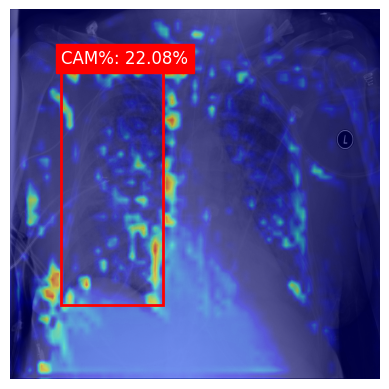

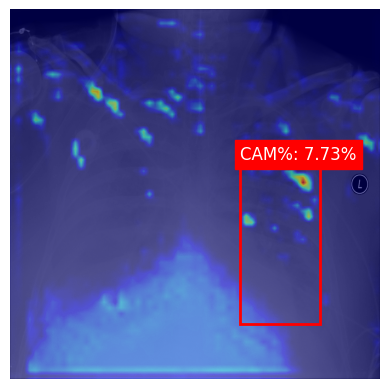

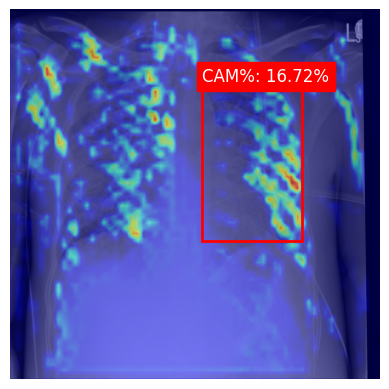

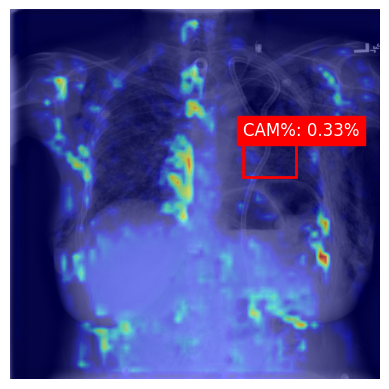

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_cam_examples(model, dataloader, device, target_layer_name, num_examples=5):
    cam_generator = CAMGenerator(model, target_layer_name, device)

    def calculate_cam_percentage(heatmap, bbox):
        x_min, y_min, x_max, y_max = map(int, bbox)
        cam_inside_box = heatmap[y_min:y_min+y_max, x_min:x_min+x_max].sum()
        total_cam = heatmap.sum()
        return cam_inside_box / total_cam if total_cam > 0 else 0

    model.eval()
    examples_plotted = 0

    with torch.no_grad():
        for batch in dataloader:
            if batch is None:
                continue
            images, bboxes, batch_targets = batch
            images, batch_targets = images.to(device), batch_targets.to(device)
            outputs = model(images)
            batch_predictions = outputs[1].cpu().numpy()

            for i in range(len(batch_targets)):
                if batch_targets[i] > 0 and batch_predictions[i] > 0.5:
                    image = images[i].cpu().numpy().transpose(1, 2, 0).squeeze()
                    bbox = bboxes[i].cpu().numpy()
                    heatmap = cam_generator.generate(images[i])
                    cam_percentage = calculate_cam_percentage(heatmap, bbox)

                    # Plot the image, heatmap, and bounding box
                    fig, ax = plt.subplots(1)
                    ax.imshow(image, cmap='gray')
                    ax.imshow(heatmap, cmap='jet', alpha=0.5)

                    # Draw the bounding box
                    x_min, y_min, width, height = bbox
                    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)

                    # Annotate the percentage
                    ax.text(x_min, y_min - 10, f'CAM%: {cam_percentage*100:.2f}%', color='white', fontsize=12, backgroundcolor='red')

                    plt.axis('off')
                    plt.show()

                    examples_plotted += 1
                    if examples_plotted >= num_examples:
                        return

# Define last convolutional layer names for each model
encoder_decoder_last_conv_layer = 'encoder.8'
encoder_only_last_conv_layer = 'encoder.8'

# Plot examples for Encoder-Decoder Model
print("Plotting CAM examples for Encoder-Decoder Model")
plot_cam_examples(encoder_decoder_model, test_loader, device, encoder_decoder_last_conv_layer)

# # Plot examples for Encoder-Only Model
print("Plotting CAM examples for Encoder-Only Model")
plot_cam_examples(encoder_only_model, test_loader, device, encoder_only_last_conv_layer)
